In [58]:
from anndata import read_h5ad
import scanpy as sc
import pandas as pd

gex = read_h5ad("../data/GSE194122/gex_preprocessed.hdf5")
latents = pd.read_csv("../data/GSE194122/scmaui_res.csv", sep="\t", index_col=0)
gex.obsm["scmaui"] = latents

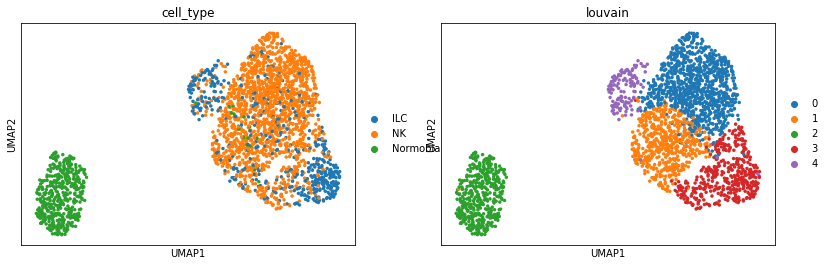

In [59]:
sc.pp.neighbors(gex, use_rep="scmaui")
sc.tl.umap(gex)
sc.tl.louvain(gex, resolution=0.3, key_added="louvain")
sc.pl.umap(gex, color=["cell_type", "louvain"])

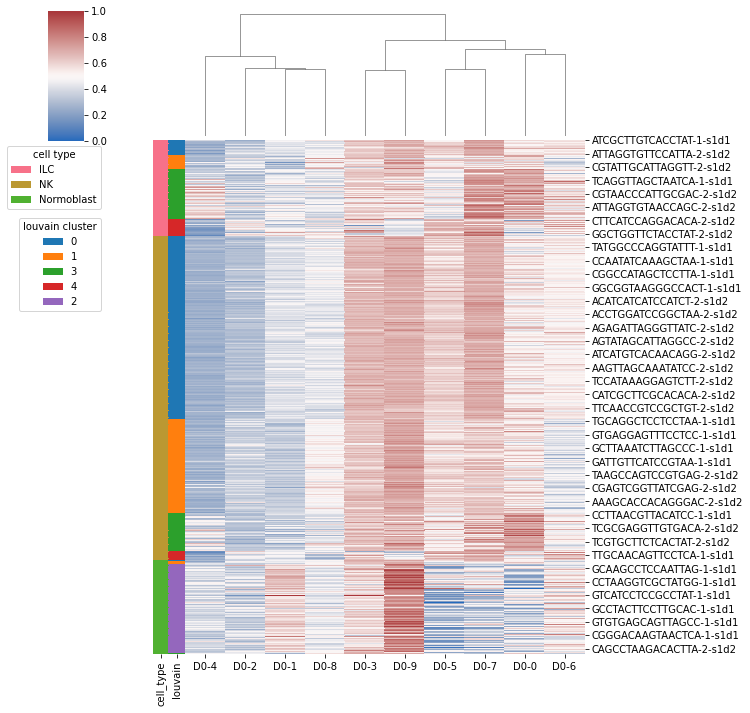

In [63]:
import seaborn as sns
import colorcet as cc
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

latents["cell_type"] = gex.obs["cell_type"]
latents["louvain"] = gex.obs["louvain"]

latents = latents.sort_values(["cell_type", "louvain"])

lut = dict(zip(latents["cell_type"].unique(), sns.color_palette("husl")))
row_colors_1 = latents["cell_type"].astype(str).map(lut)
gt_handles_1 = [Patch(facecolor=lut[name]) for name in lut]

latents["louvain"] = latents["louvain"].astype(str)
lut2 = dict(zip(latents["louvain"].unique(), sns.color_palette("tab10")))
row_colors_2 = latents["louvain"].map(lut2)
gt_handles_2 = [Patch(facecolor=lut2[name]) for name in lut2]

row_colors = pd.concat([row_colors_1,row_colors_2],axis=1)


sns.clustermap(data=latents.drop(columns=["cell_type", "louvain"]), 
               row_colors=row_colors, row_cluster=False, cmap="vlag", standard_scale=1) 
l1 = plt.legend(gt_handles_1, lut, title='cell type', 
           bbox_to_anchor=(0.1, 0.8), bbox_transform=plt.gcf().transFigure, loc='upper right')
plt.gca().add_artist(l1)

plt.legend(gt_handles_2, lut2, title='louvain cluster', 
           bbox_to_anchor=(0.1, 0.7), bbox_transform=plt.gcf().transFigure, loc='upper right')
plt.show()

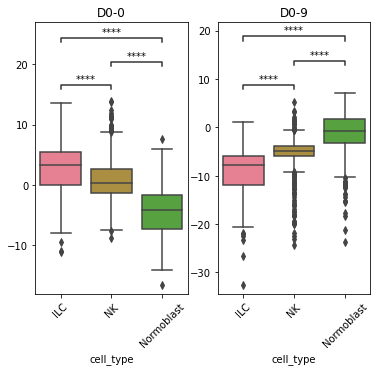

In [114]:
from statannot import add_stat_annotation

latents["cell_type"] = gex.obs["cell_type"]
latents["louvain"] = gex.obs["louvain"]
latents_numbers = [0, 9]
fig, ax = plt.subplots(1,2, figsize=(6,5))
for j,i in enumerate(latents_numbers):
    
    sns.boxplot(data=latents, x="cell_type", y="D0-%d"%i, ax=ax[j], 
                palette=sns.color_palette("husl"))
    add_stat_annotation(ax[j], data=latents, x="cell_type", y="D0-%d"%i,
                        box_pairs=[("ILC", "NK"),
                                  ("ILC", "Normoblast"),
                                  ("NK", "Normoblast")
                                  ], 
                        test='t-test_ind', text_format='star', verbose=0)
    ax[j].set_title("D0-%d"%i)
    ax[j].set_ylabel(None)
    ax[j].set_xticklabels(ax[j].get_xticklabels(),rotation=45)


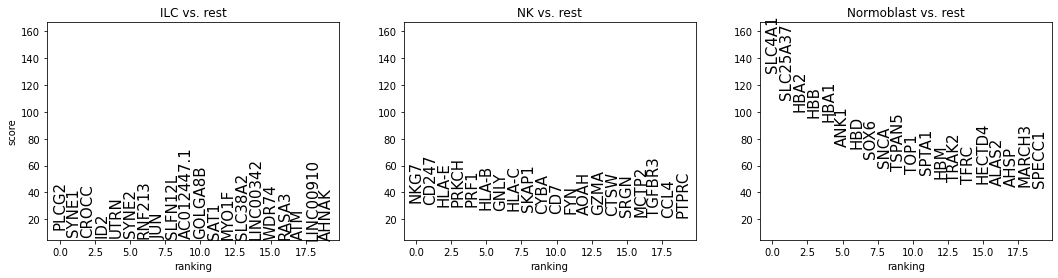

In [116]:
sc.tl.rank_genes_groups(adata = gex, groupby="cell_type")
rank_genes = list(chain(*gex.uns["rank_genes_groups"]["names"][:15]))

sc.pl.rank_genes_groups(gex, fontsize=15)

In [109]:
from tqdm.notebook import tqdm
pd_list = list()
for i in tqdm(range(len(rank_genes))):
    a = gex.to_df().loc[:,rank_genes[i]].dropna()
    if len(a) > 2:
        b=pd.DataFrame(gex.obsm["scmaui"].loc[a.index,:].corrwith(a))
        b.columns=[rank_genes[i]]
        pd_list.append(b)
corr_matrix = pd.concat(pd_list,axis=1)
corr_matrix

  0%|          | 0/45 [00:00<?, ?it/s]

,PLCG2,NKG7,SLC4A1,SYNE1,CD247,SLC25A37,CROCC,HLA-E,HBA2,ID2,...,SPTA1,MYO1F,AOAH,HBM,SLC38A2,GZMA,TRAK2,LINC00342,CTSW,TFRC
D0-0,0.222984,-0.061386,-0.522248,0.414163,0.279934,-0.502115,0.197789,0.100676,-0.449438,0.133698,...,-0.533532,0.287663,0.413958,-0.508669,0.209268,-0.135384,-0.455508,0.205465,-0.128718,-0.496338
D0-1,0.102744,-0.294069,0.733971,-0.380536,-0.514631,0.724124,0.004917,-0.397093,0.723639,-0.063153,...,0.688066,-0.265537,-0.532910,0.686394,-0.078670,-0.210096,0.651466,-0.115497,-0.228911,0.653505
D0-2,0.060825,-0.182320,0.177231,-0.149271,-0.209181,0.167871,0.009383,-0.182676,0.145350,-0.070733,...,0.196499,-0.103448,-0.183125,0.168975,-0.018944,-0.134875,0.167492,0.004253,-0.089619,0.188334
D0-3,-0.066147,0.274374,-0.225865,0.152078,0.238546,-0.217172,-0.002332,0.249186,-0.199703,0.084214,...,-0.218899,0.082985,0.164529,-0.196450,0.024860,0.215318,-0.208905,-0.006897,0.146466,-0.201425
D0-4,0.316775,-0.618691,0.269332,-0.070700,-0.375141,0.268978,0.092059,-0.500104,0.319462,-0.115190,...,0.248369,-0.006260,-0.197693,0.265912,-0.018399,-0.465396,0.235184,0.119485,-0.415223,0.236632
D0-5,-0.186799,0.617449,-0.722418,0.367212,0.574447,-0.734933,-0.029936,0.572336,-0.697398,0.155525,...,-0.625989,0.231724,0.491977,-0.598919,0.076340,0.476484,-0.662657,0.040605,0.379808,-0.614719
D0-6,0.031756,0.023015,0.063865,0.099320,0.006409,0.056172,0.014126,0.001113,0.094500,0.023619,...,0.062044,0.059117,0.006874,0.075319,0.025572,0.012150,0.057620,0.014227,-0.074783,0.034795
D0-7,0.108934,0.547090,-0.775694,0.448937,0.440450,-0.779705,0.203667,0.502650,-0.666838,0.355245,...,-0.721090,0.310120,0.423980,-0.645415,0.244362,0.412633,-0.728094,0.119058,0.291726,-0.691880
D0-8,-0.005012,-0.046233,-0.071926,-0.076076,-0.007792,-0.074118,-0.068667,-0.029144,-0.069258,-0.076956,...,-0.057508,-0.029957,-0.003085,-0.058828,-0.086709,-0.035297,-0.067185,0.000265,0.070763,-0.050235
D0-9,-0.148817,-0.219753,0.438633,-0.284482,-0.213886,0.425056,-0.150793,-0.225501,0.384192,-0.201866,...,0.457249,-0.211525,-0.234614,0.423575,-0.164276,-0.155442,0.400800,-0.093910,-0.078564,0.415157


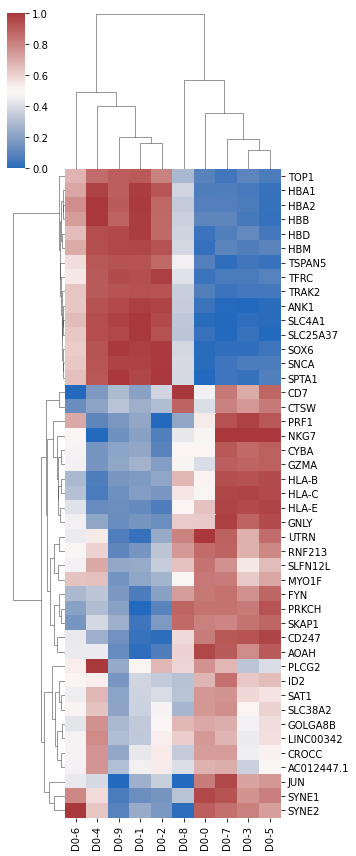

In [113]:
sns.clustermap(data=corr_matrix.T, row_cluster=True, cmap="vlag", standard_scale=1, figsize=(5,12)) 
